In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision 
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Cihaz ayarı (GPU varsa kullanır, yoksa CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hiperparametreler
NUM_CLASSES = 4
BATCH_SIZE = 16
NUM_EPOCHS = 20     
LEARNING_RATE = 0.001
SEED = 42


torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed(SEED)

print(f"Kullanılan Cihaz: {device}")
print("Hücre 1 Tamamlandı.")

Kullanılan Cihaz: cpu
Hücre 1 Tamamlandı.


In [15]:
# Veri seti yolu
DATA_DIR = r'C:\Users\ramis\Downloads\archive (1)\Multi-class Weather Dataset' 

# Train için Augmentation (Veri Çoğaltma)
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Test/Val için Standart Dönüşüm
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Veriyi klasörden çekme
full_dataset = datasets.ImageFolder(DATA_DIR, transform=None) 

# Veri boyutları
toplam_veri = len(full_dataset)
train_size = int(0.6 * toplam_veri)
val_size = int(0.2 * toplam_veri)
test_size = toplam_veri - (train_size + val_size)

# Split işlemi
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(SEED)
)

# Transformları atama
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# DataLoader'lar
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0),
    'test': DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
}

dataset_sizes = {'train': train_size, 'val': val_size, 'test': test_size}
class_names = full_dataset.classes

print(f"Sınıflar: {class_names}")
print(f"Veri Dağılımı -> Train: {train_size}, Val: {val_size}, Test: {test_size}")
print("Hücre 2 Tamamlandı.")

Sınıflar: ['Cloudy', 'Rain', 'Sunrise', 'Sunshine']
Veri Dağılımı -> Train: 675, Val: 225, Test: 225
Hücre 2 Tamamlandı.


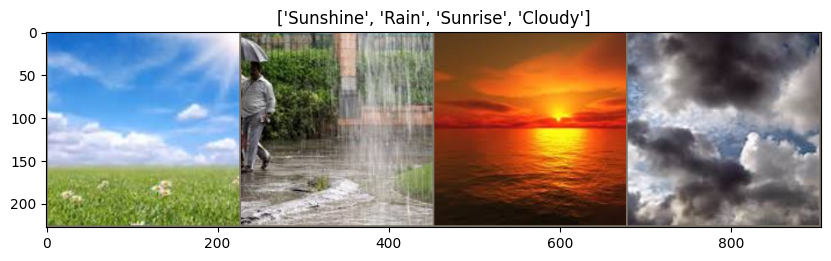

Hücre 3 (Görselleştirme) Tamamlandı.


In [16]:
def imshow(inp, title=None):
    """Tensörü ekranda resim olarak göstermek için fonksiyon"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Bir batch veri al
inputs, classes = next(iter(dataloaders['train']))

# Grid oluştur ve göster
out = torchvision.utils.make_grid(inputs[:4]) # İlk 4 resmi al
plt.figure(figsize=(10, 5))
imshow(out, title=[class_names[x] for x in classes[:4]])
print("Hücre 3 (Görselleştirme) Tamamlandı.")

In [17]:
class LeNet5_Improved(nn.Module):
    def __init__(self, num_classes=4):
        super(LeNet5_Improved, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        
       
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.dropout1 = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.5) 
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 53 * 53)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x) 
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

model_ft = LeNet5_Improved(num_classes=NUM_CLASSES).to(device)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("Model: LeNet-5 (Improved) Hazır.")
print("Hücre 4 Tamamlandı.")

Model: LeNet-5 (Improved) Hazır.
Hücre 4 Tamamlandı.


In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    # Grafik çizimi için verileri saklayacağımız listeler
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}') 
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Geçmişi kaydet
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.item()
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f'\nEğitim tamamlandı: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'En İyi Val Accuracy: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history

print("Hücre 5 Tamamlandı.")

Hücre 5 Tamamlandı.


In [19]:
print("Eğitim Başlıyor...")
model_ft, history = train_model(model_ft, dataloaders, criterion, optimizer_ft, NUM_EPOCHS)
print("Eğitim Bitti.")

Eğitim Başlıyor...
Epoch 1/20
----------
train Loss: 1.2161 Acc: 0.4874
val Loss: 0.8276 Acc: 0.6622
Epoch 2/20
----------
train Loss: 0.8033 Acc: 0.6370
val Loss: 0.6025 Acc: 0.7422
Epoch 3/20
----------
train Loss: 0.6537 Acc: 0.7511
val Loss: 0.5621 Acc: 0.7867
Epoch 4/20
----------
train Loss: 0.6134 Acc: 0.7926
val Loss: 0.5003 Acc: 0.7956
Epoch 5/20
----------
train Loss: 0.4756 Acc: 0.8356
val Loss: 0.4234 Acc: 0.8489
Epoch 6/20
----------
train Loss: 0.5068 Acc: 0.8163
val Loss: 0.5062 Acc: 0.8311
Epoch 7/20
----------
train Loss: 0.3627 Acc: 0.8785
val Loss: 0.4015 Acc: 0.8711
Epoch 8/20
----------
train Loss: 0.3801 Acc: 0.8859
val Loss: 0.4504 Acc: 0.8356
Epoch 9/20
----------
train Loss: 0.3110 Acc: 0.8963
val Loss: 0.4922 Acc: 0.8000
Epoch 10/20
----------
train Loss: 0.2781 Acc: 0.9111
val Loss: 0.4906 Acc: 0.8578
Epoch 11/20
----------
train Loss: 0.1677 Acc: 0.9437
val Loss: 0.5089 Acc: 0.8533
Epoch 12/20
----------
train Loss: 0.1616 Acc: 0.9437
val Loss: 0.3846 Acc: 0

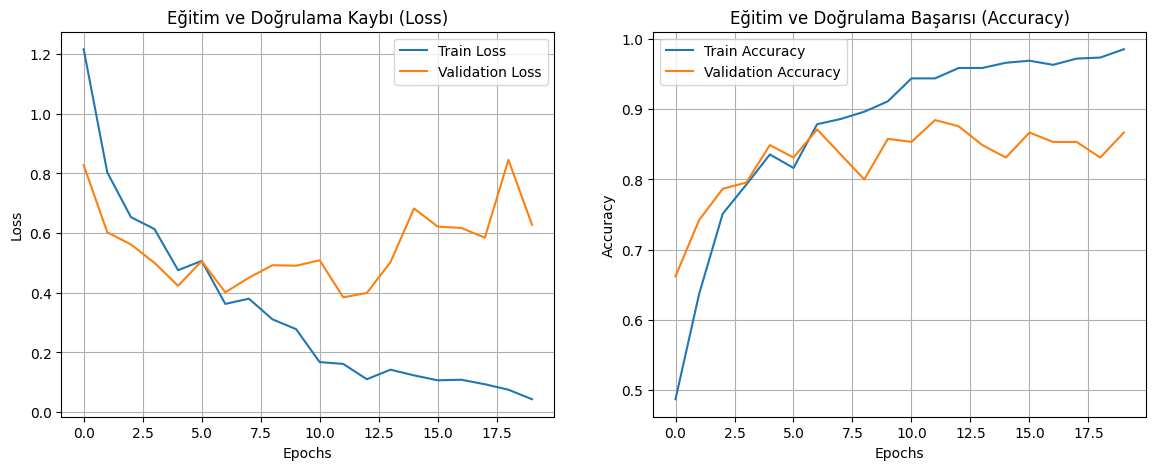

Hücre 7 (Grafikler) Tamamlandı.


In [20]:
plt.figure(figsize=(14, 5))

# Loss Grafiği
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Eğitim ve Doğrulama Kaybı (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Grafiği
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Eğitim ve Doğrulama Başarısı (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()
print("Hücre 7 (Grafikler) Tamamlandı.")

In [21]:
def evaluate_model_table(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in dataloader['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    results = pd.DataFrame({
        'Model': ['LeNet-5 (Improved)'],
        'Accuracy': [acc],
        'Precision': [prec],
        'Recall': [rec],
        'F1 Score': [f1]
    })
    
    return results, y_true, y_pred

print("\n--- TEST SONUÇLARI ---")
df_results, y_true, y_pred = evaluate_model_table(model_ft, dataloaders)
print(df_results.to_string(index=False, float_format="%.4f"))
print("Hücre 8 Tamamlandı.")


--- TEST SONUÇLARI ---
             Model  Accuracy  Precision  Recall  F1 Score
LeNet-5 (Improved)    0.8667     0.8714  0.8667    0.8671
Hücre 8 Tamamlandı.


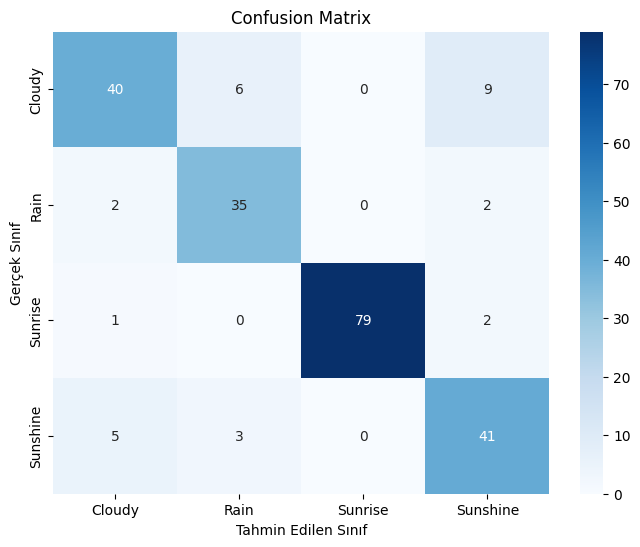

Hücre 9 (Heatmap) Tamamlandı.


In [22]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.show()

print("Hücre 9 (Heatmap) Tamamlandı.")